# Введение

**Основные задачи, решаемые в страховании**
* Классические задачи:
    * тарификация
    * антифрод
    * расчет комиссии посредников
* ML дало развитие задачам:
    * скоринг клиентов
    * оценка риска
    * оценка ущерба (резерва)
    * вероятность пролонгации
    * вероятность покупки опций
    * вероятность кросс-продаж
    * оценка параметров, неизвестных на начальном этапе (например, балл БКИ на предварительном расчете)
    * варианты развития убытка (вероятность отказа в выплате, вероятность суда, мошенничества)
    * распознавание марок-моделей ТС по фото
    * распознавание повреждений ТС по фото

**Риски, оцениваемые в автостраховании**
* Повреждения кузова
  * наш клиент виновен / невиновен
  * крупные / мелкие убытки
* Ущерб здоровью и жизни
* Обязательная гражданская ответственность (ОСАГО)
* Добровольная гражданская ответственность (ДАГО)
* Повреждения в результате действия третьих лиц
* Тоталь
* Угон
* Прочее

**Основная идея метода бустинга**
* Строится модель, прогнозирующая целевую переменную
* Находятся отклонения между прогнозными и фактическими значениями
* Отклонения - новая целевая переменная
* Строится модель, прогнозирующая отклонения
* Находятся новые отклонения после применения двух моделей
* Новые отклонения - снова целевая переменная
* ...

  ![](https://drive.google.com/uc?export=view&id=1S6rBG3Jn0nTww-X_Fs3h00F9OvkXHgUA)

**Особенности бустинга "деревянных" моделей**
* Бόльшая склонность к переобучению, чем у линейных моделей
* Требовательность к подбору гиперпараметров
* Сложность с трактовкой значимости параметров

**Схема решающего дерева для задачи классификации**

  ![](https://drive.google.com/uc?export=view&id=1WlLe4akj2-8LsEeWoS8lCDzATkMKzcO1)

Основная мера неоднородности при построении деревьев - энтропия Шеннона
  ![](https://drive.google.com/uc?export=view&id=16FWKv29X4qFkvi8W0MMN9rkOm4TFByq8) ,
где p - вероятность состояния, i - состояние системы. Чем выше энтропия, тем больше хаоса.

  ![](https://drive.google.com/uc?export=view&id=1Dl9u-uwnpBn6a4ORFBXrXMFMDrbBjLtH)

  ![](https://drive.google.com/uc?export=view&id=1f77y84obWiPmX2W57N5cdm4RlVQCz3wf)

  ![](https://drive.google.com/uc?export=view&id=1amL7hYh0D3LEJQt0Ntr1JdqClEgNDODV)

 Прирост информации (изменение энтропии)
  ![](https://drive.google.com/uc?export=view&id=1LPgPB2aSvvhVYa2qD3Kgy-XTD-2oVx5G)

**Алгоритм построения решающих деревьев**
* Вычисляем энтропию исходного множества
* Если энтропия равна 0, значит все объекты принадлежат к одному классу
* Разбиваем исходное множество на два подмножества, вычисляем изменение энтропии
* Среди всех возможных разбиений выбираем то, у которого изменение энтропии наибольшее
* Повторяем процесс: разбиваем каждое из полученных подмножеств

  ![](https://drive.google.com/uc?export=view&id=1Q-qEQLZ-sjPQrei-EBxpmBS9yfZTKU2o)

**Для задачи регрессии**
* Мера неоднородности - это ошибка на выборке

**Градиентный спуск**
* Поиск минимума ошибки за счет движения в сторону антиградиента

**Что работает лучше, деревья решений или линейные модели?**
* Ответ зависит от ситуации с данными
* В страховых задачах оценки риска преимущество "деревянных" моделей неочевидно

# Решение задачи оценки ожидаемых выплат по полису КАСКО методом градиентного бустинга

## Предобработка данных

In [1]:
# Подключение к Google drive

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd

In [58]:
# Загрузим набор данных

df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/freMPL-R.csv', low_memory=False)
df = df.loc[df.Dataset.isin([5, 6, 7, 8, 9])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Exposure           115155 non-null  float64
 1   LicAge             115155 non-null  int64  
 2   RecordBeg          115155 non-null  object 
 3   RecordEnd          59455 non-null   object 
 4   Gender             115155 non-null  object 
 5   MariStat           115155 non-null  object 
 6   SocioCateg         115155 non-null  object 
 7   VehUsage           115155 non-null  object 
 8   DrivAge            115155 non-null  int64  
 9   HasKmLimit         115155 non-null  int64  
 10  BonusMalus         115155 non-null  int64  
 11  ClaimAmount        115155 non-null  float64
 12  ClaimInd           115155 non-null  int64  
 13  ClaimNbResp        115155 non-null  float64
 14  ClaimNbNonResp     115155 non-null  float64
 15  ClaimNbParking     115155 non-null  float64
 16  Cl

В первом уроке мы заметили отрицательную величину убытка для некоторых наблюдений. Заметим, что для всех таких полисов переменная "ClaimInd" принимает только значение 0. Поэтому заменим все соответствующие значения "ClaimAmount" нулями.

In [59]:
NegClaimAmount = df.loc[df.ClaimAmount < 0, ['ClaimAmount','ClaimInd']]
print('Unique values of ClaimInd:', NegClaimAmount.ClaimInd.unique())
NegClaimAmount.head()

Unique values of ClaimInd: [0]


,ClaimAmount,ClaimInd
82,-74.206042,0
175,-1222.585196,0
177,-316.288822,0
363,-666.758610,0
375,-1201.600604,0


In [0]:
df.loc[df.ClaimAmount < 0, 'ClaimAmount'] = 0

Перекодируем переменные типа `object` с помощью числовых значений

In [0]:
def SeriesFactorizer(series):
    series, unique = pd.factorize(series)
    reference = {x: i for x, i in enumerate(unique)}
    print(reference)
    return series, reference

In [62]:
df.Gender, GenderRef = SeriesFactorizer(df.Gender)

{0: 'Male', 1: 'Female'}


In [63]:
df.MariStat, MariStatRef = SeriesFactorizer(df.MariStat)

{0: 'Other', 1: 'Alone'}


Для переменных, содержащих более 2 значений, различия между которыми не могут упорядочены, используем фиктивные переменные (one-hot encoding).

In [64]:
list(df.VehUsage.unique())

['Professional', 'Private+trip to office', 'Private', 'Professional run']

In [65]:
VU_dummies = pd.get_dummies(df.VehUsage, prefix='VehUsg', drop_first=False)
VU_dummies.head()

,VehUsg_Private,VehUsg_Private+trip to office,VehUsg_Professional,VehUsg_Professional run
0,0,0,1,0
1,0,0,1,0
2,0,1,0,0
3,0,1,0,0
4,1,0,0,0


Фактор "SocioCateg" содержит информацию о социальной категории в виде кодов классификации CSP. Агрегируем имеющиеся коды до 1 знака, а затем закодируем их с помощью one-hot encoding.

[Wiki](https://fr.wikipedia.org/wiki/Professions_et_cat%C3%A9gories_socioprofessionnelles_en_France#Cr%C3%A9ation_de_la_nomenclature_des_PCS)

[Более подробный классификатор](https://www.ast74.fr/upload/administratif/liste-des-codes-csp-copie.pdf)

In [0]:
df['SocioCateg'] = df.SocioCateg.str.slice(0,4)

In [67]:
pd.DataFrame(df.SocioCateg.value_counts().sort_values()).rename({'SocioCateg': 'Frequency'}, axis=1)

,Frequency
CSP7,14
CSP3,1210
CSP1,2740
CSP2,3254
CSP4,7648
CSP6,24833
CSP5,75456


In [0]:
df = pd.get_dummies(df, columns=['VehUsage','SocioCateg'])

Теперь, когда большинство переменных типа `object` обработаны, исключим их из набора данных за ненадобностью.

In [0]:
df = df.select_dtypes(exclude=['object'])

Также создадим такую переменную, как квадрат возраста.

In [70]:
df['DrivAgeSq'] = df.DrivAge.apply(lambda x: x**2)
df.head()

,Exposure,LicAge,Gender,MariStat,DrivAge,HasKmLimit,BonusMalus,ClaimAmount,ClaimInd,ClaimNbResp,ClaimNbNonResp,ClaimNbParking,ClaimNbFireTheft,ClaimNbWindscreen,OutUseNb,RiskArea,VehUsage_Private,VehUsage_Private+trip to office,VehUsage_Professional,VehUsage_Professional run,SocioCateg_CSP1,SocioCateg_CSP2,SocioCateg_CSP3,SocioCateg_CSP4,SocioCateg_CSP5,SocioCateg_CSP6,SocioCateg_CSP7,DrivAgeSq
0,0.083,332,0,0,46,0,50,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,9.0,0,0,1,0,0,0,0,0,1,0,0,2116
1,0.916,333,0,0,46,0,50,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,9.0,0,0,1,0,0,0,0,0,1,0,0,2116
2,0.550,173,0,0,32,0,68,0.0,0,0.0,2.0,0.0,0.0,0.0,0.0,7.0,0,1,0,0,0,0,0,0,1,0,0,1024
3,0.089,364,1,0,52,0,50,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0,1,0,0,0,0,0,0,1,0,0,2704
4,0.233,426,0,0,57,0,50,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,1,0,0,0,0,0,0,0,0,1,0,3249


Для моделирования частоты убытков сгенерируем показатель как сумму индикатора того, что убыток произошел ("ClaimInd") и количества заявленных убытков по различным видам ущерба за 4 предшествующих года ("ClaimNbResp", "ClaimNbNonResp", "ClaimNbParking", "ClaimNbFireTheft", "ClaimNbWindscreen").

В случаях, если соответствующая величина убытка равняется нулю, сгенерированную частоту также обнулим.

In [0]:
df['ClaimsCount'] = df.ClaimInd + df.ClaimNbResp + df.ClaimNbNonResp + df.ClaimNbParking + df.ClaimNbFireTheft + df.ClaimNbWindscreen
df.loc[df.ClaimAmount == 0, 'ClaimsCount'] = 0
df.drop(["ClaimNbResp", "ClaimNbNonResp", "ClaimNbParking", "ClaimNbFireTheft", "ClaimNbWindscreen"], axis=1, inplace=True)

In [72]:
pd.DataFrame(df.ClaimsCount.value_counts()).rename({'ClaimsCount': 'Policies'}, axis=1)

,Policies
0.0,104286
2.0,3529
1.0,3339
3.0,2310
4.0,1101
5.0,428
6.0,127
7.0,26
8.0,6
9.0,2


In [73]:
import plotly.express as px
fig = px.scatter(df, x='ClaimsCount', y='ClaimAmount', title='Зависимость между частотой и величиной убытков')
fig.show()

Для моделирования среднего убытка можем рассчитать его как отношение величины убытков к их частоте.

In [0]:
dfAC = df[df.ClaimsCount > 0].copy()
dfAC['AvgClaim'] = dfAC.ClaimAmount/dfAC.ClaimsCount

## Разделение набора данных на обучающую, валидационную и тестовую выборки

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
# Разбиение датасета для частоты на train/val/test

x_train_c, x_test_c, y_train_c, y_test_c = train_test_split(df.drop(['ClaimInd', 'ClaimAmount', 'ClaimsCount'], axis=1), df.ClaimsCount, test_size=0.3, random_state=1)
x_valid_c, x_test_c, y_valid_c, y_test_c = train_test_split(x_test_c, y_test_c, test_size=0.5, random_state=1)

In [0]:
# Разбиение датасета для среднего убытка на train/val/test 

x_train_ac, x_test_ac, y_train_ac, y_test_ac = train_test_split(dfAC.drop(['ClaimInd', 'ClaimAmount', 'ClaimsCount', 'AvgClaim'], axis=1), dfAC.AvgClaim, test_size=0.3, random_state=1)
x_valid_ac, x_test_ac, y_valid_ac, y_test_ac = train_test_split(x_test_ac, y_test_ac, test_size=0.5, random_state=1)

## Градиентный бустинг

Градиентный бустинг - ансамблевый метод машинного обучения, использующийся для задач классификации, регрессии и ранжирования. Ансамбль представляет собой композицию простых базовых алгоритмов, в качестве которых обычно используются деревья решений. 

Классический алгоритм GBM был предложен [Джеромом Фридманом в
1999 году](https://statweb.stanford.edu/~jhf/ftp/trebst.pdf). Популярность методов GBM пришла в 2015-2016 гг. благодаря большому
успеху библиотеки XGBoost в соревнованиях Kaggle.

Популярные библиотеки для GBM:
* XGBoost (eXtreme Gradient Boosting)
    * скорость, масштабируемость, поддержка распределенных вычислений
    * добавление компоненты регуляризации, отсутствовавшей в классическом алгоритме GBM
* LightGBM
    * использование алгоритмов, основанных на гистограммах, которые позволяют сократить время исполнения и потребление памяти в процессе обучения моделей. 
* CatBoost (Categorical Boosting)
    * предназначается для эффективной работы с категориальными признаками

Все перечисленные библиотеки зачастую имеют сравнимый результат.

### Теория (XGBoost)

**Модель**

Пусть $y_i$ – значение переменной, которое необходимо предсказать, $x_i$ – входные данные.

Модель имеет вид
$$\hat{y}_i = \sum_{k=1}^K f_k(x_i),\hspace{10pt} f_k \in \mathcal{F},$$
где $K$ – количество деревьев, $f$ – функция на пространстве $\mathcal{F}$, которое содержит все возможные деревья решений.

**Целевая функция**
$$\text{Obj}(\theta) = L(\theta) + \Omega(\theta),$$
где 
* $\theta$ – параметры модели;
* $L$ – величина потерь на обучающей выборке  (насколько хорошо модель описывает данные?);
* $\Omega$ – компонента, отвечающая за регуляризацию (насколько модель сложная?).

Тогда для представленной модели $\theta = \{f_1,f_2,\cdots,f_K\}$,

$$\text{Obj} = \sum_{i=1}^n l(y_i, \hat{y}_i) + \sum_{k=1}^K\Omega(f_k),$$
где $l(y_i, \hat{y}_i)$ – функция потерь.

**Обучение**

Необходимо обучить функции $f_i$, каждая из которых включает структуру дерева и значения листьев.

Обозначим $\hat{y}_i^{(t)}$ предсказанное значение на шаге $t$. Тогда целевая функция имеет вид:
$$\text{Obj} = \sum_{i=1}^n l\left(y_i, \hat{y}_i^{(t)}\right) + \sum_{i=1}^t\Omega(f_i).$$

Обучение деревьев происходит поочередно, начиная с постоянного предсказания:
$$\begin{split}\hat{y}_i^{(0)} &= 0\\
\hat{y}_i^{(1)} &= f_1(x_i) = \hat{y}_i^{(0)} + f_1(x_i)\\
\hat{y}_i^{(2)} &= f_1(x_i) + f_2(x_i)= \hat{y}_i^{(1)} + f_2(x_i)\\
&\dots\\
\hat{y}_i^{(t)} &= \sum_{k=1}^t f_k(x_i)= \hat{y}_i^{(t-1)} + f_t(x_i)\end{split}$$

На каждом шаге выбирается дерево, которое оптимизирует целевую функцию.
$$\begin{split}\text{Obj}^{(t)} & = \sum_{i=1}^n l\left(y_i, \hat{y}_i^{(t)}\right) + \sum_{i=1}^t\Omega(f_i) \\
          & = \sum_{i=1}^n l\left(y_i, \hat{y}_i^{(t-1)} + f_t(x_i)\right) + \Omega(f_t) + \mathrm{constant}\end{split}$$


Для упрощения задачи оптимизации для заданной функции потерь используется разложение Тейлора:
$$F(x+\Delta x) \simeq F(x) + F'(x)\Delta x + \frac{1}{2} F''(x)\Delta x^2 + \dots$$

Тогда обозначив градиент и гессиан функции потерь соответственно
$$g_i = \partial_{\hat{y}_i^{(t-1)}} l(y_i, \hat{y}_i^{(t-1)}),\hspace{10pt}h_i = \partial_{\hat{y}_i^{(t-1)}}^2 l(y_i, \hat{y}_i^{(t-1)}),$$
целевая функция будет иметь вид
$$\text{Obj}^{(t)} = \sum_{i=1}^n [l(y_i, \hat{y}_i^{(t-1)}) + g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i)] + \Omega(f_t) + \mathrm{constant}.$$

Убирая константы на шаге $t$, целевая функция упрощается в виде:
$$\text{Obj}^{(t)} = \sum_{i=1}^n [g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i)] + \Omega(f_t).$$

Таким образом, величина потерь $L$ зависит только от $g_i$ и $h_i$.

Благодаря этому, XGBoost поддерживает пользовательские целевые функции, для которых достаточно задать градиент и гессиан функции потерь.

**Регуляризация**

Для начала определим дерево $f_t(x)$:
$$f_t(x) = w_{q(x)}, w \in R^T, q:R^d\rightarrow \{1,2,\cdots,T\},$$
где $w$ – вектор значений на листьях дерева, $T$ – количество листьев, $q$ – функция, которая каждой точке набора данных ставит в соответствие лист дерева.

Тогда сложность модели имеет вид
$$\Omega(f) = \gamma T + \frac{1}{2}\lambda \sum_{j=1}^T w_j^2+ \alpha \sum_{j=1}^T |w_j|,$$
где $\gamma$ – штраф на сложность деревьев, $\lambda$ – сила регуляризации $\ell_2$, $\alpha$ – сила регуляризации $\ell_1$.

**Переобучение**
Для контроля переобучения помимо параметров $\gamma$, $\alpha$ и $\lambda$ используются также параметры:
* Контролирующие сложность модели напрямую 
    * максимальная глубина дерева (`max_depth`)
    * минимальный вес в узле, ниже которого прекращается дальнейшее разделение в этом узле (`min_child_weight`)
* Добавляющие случайность, повышая устойчивость к зашумлению
    * $\eta$ – величина шага. $\eta \in (0,1]$.
    Вместо $\hat{y}_i^{(t)} = \hat{y}_i^{(t-1)} + f_t(x_i)$ используется 
    $\hat{y}_i^{(t)} = \hat{y}_i^{(t-1)} + \eta\cdot f_t(x_i)$
    * Доля подвыборки наблюдений для построения деревьев (`subsample`)
    * Доля подвыборки признаков для построения деревьев (`colsample_bytree`)

Теория, стоящая за оценкой весов на листьях и нахождением разделений выходит за рамки нашего рассмотрения.

* [Chen, Tianqi, and Carlos Guestrin. "Xgboost: A scalable tree boosting system." ](https://arxiv.org/pdf/1603.02754.pdf)
* [XGBoost Documentation](https://xgboost.readthedocs.io/en/latest/tutorials/model.html)
* [А. Дьяконов «Введение в анализ данных и машинное обучение». Градиентный бустинг](https://alexanderdyakonov.files.wordpress.com/2017/06/book_boosting_pdf.pdf)
* [Rokach, Lior. Ensemble Learning: Pattern Classification Using Ensemble Methods (Second Edition)](https://books.google.ru/books/about/Ensemble_Learning_Pattern_Classification.html?id=_AmMDwAAQBAJ&redir_esc=y)

### Выбор гиперпараметров

Основные гиперпараметры, используемые в библиотеке XGBoost
* _objective_ - функция распределения
* _eta_ - размер шага
* _max_depth_ - максимальная глубина дерева
* _min_child_weight_ - минимальный вес, необходимый дочерним элементам
* _subsample_ - доля подвыборки для каждой итерации
* _colsample_bytree_ - доля колонок, участвующих в итерации
* _alpha_ - сила регуляризации L1
* _lambda_ - сила регуляризации L2
* _gamma_ - штраф на сложность деревьев
* _num_boost_round_ - число итераций (фиксируем, не следует менять вместе с _eta_)
* _early_stopping_rounds_ - число итераций для остановки, если не произошло улучшение метрики (фиксируем) 

Стратегии подбора гиперпараметров:
* Поиск на сетке (Grid Search, Randomized Search)
* Покоординатный спуск (Coordinate Descent)
* Генетические алгоритмы (Genetic Algorithms)
* Байесовская оптимизация
* ...

[Использование некоторых алгоритмов подбора гиперпараметров для  XGBoost](https://towardsdatascience.com/doing-xgboost-hyper-parameter-tuning-the-smart-way-part-1-of-2-f6d255a45dde)

Для подбора параметров воспользуемся реализацией Tree-structured Parzen Estimator (TPE) в библиотеке `Hyperopt`. Данный метод использует подход последовательной оптимизации, основанной на модели (sequential model-based optimization, SMBO).

Методы SMBO последовательно строят модели, аппроксимирующие результат гиперпараметров, исходя из предыдущих измерений, и затем делают выбор новых гиперпараметров для проверки модели.

Подход TPE моделирует вероятности $P(x|y)$ и $P(y)$, где $x$ – гиперпараметры, а $y$ – соответствующий им показатель качества. Вероятность $P(x|y)$ моделируется путем замены распределений априорной вероятности с помощью непараметрических оценок плотности.

* [Bergstra, James S., et al. "Algorithms for hyper-parameter optimization." Advances in neural information processing systems. 2011.](https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf)

In [0]:
import xgboost as xgb
from hyperopt import hp, tpe, space_eval
from hyperopt.fmin import fmin

### Построение модели градиентного бустинга для частоты страховых случаев

In [0]:
# Конвертация наборов данных в формат, поддерживающийся XGBoost

train_c = xgb.DMatrix(x_train_c.drop(['Exposure'], axis=1), (y_train_c+1))
valid_c = xgb.DMatrix(x_valid_c.drop(['Exposure'], axis=1), (y_valid_c+1))
test_c = xgb.DMatrix(x_test_c.drop(['Exposure'], axis=1), (y_test_c+1))

In [0]:
# Зададим функцию Deviance для распределения Пуассона

def xgb_eval_dev_poisson(yhat, dtrain):
    """
    Function for Poisson Deviance evaluation

    :param yhat: np.ndarray object with predictions
    :param dtrain: xgb.DMatrix object with target variable
    :return: (str, float), tuple with metrics name and its value
    """
    y = dtrain.get_label()
    return 'dev_poisson', 2 * np.sum( y*np.log(y/yhat) - (y-yhat) )

In [0]:
# Определим функцию для оптимизации гиперпараметров алгоритмом TPE

def objective(params):
    """
    Objective function for hyperopt. Optimizing mean cross-validation error with XGBoost.

    :param params: dict object passed to hyperopt fmin() function
    :return: float, mean cross-validation error for XGBoost utilizing params
    """
    params['max_depth'] = int(params['max_depth'])
    n_b_r = int(params.pop('num_boost_round'))
    data = params.pop('data')
    feval = params.pop('feval')
    nfold = params.pop('nfold')
    e_s_r = params.pop('early_stopping_rounds')
    maximize = params.pop('maximize')
    cv_result = xgb.cv(params, data, num_boost_round=n_b_r, nfold=nfold, seed=0, maximize=maximize,
                       feval=feval, early_stopping_rounds=e_s_r)
    name, _ = feval(data.get_label(), data)
    score = cv_result['test-{}-mean'.format(name)][-1:].values[0]
    return score

In [0]:
# Определим границы, в которых будем искать гиперпараметры

space_freq = {'data': train_c,
              'objective': 'count:poisson',
              'feval': xgb_eval_dev_poisson,
              'maximize': False,
              'nfold': 5,
              'early_stopping_rounds': 20,
              'num_boost_round': 300,  # hp.choice('num_boost_round', [50, 300, 500])
              'max_depth': hp.choice('max_depth', [5, 8, 10, 12, 15]),
              'min_child_weight': hp.uniform('min_child_weight', 0, 50),
              'subsample': hp.uniform('subsample', 0.5, 1),
              'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
              'alpha': hp.uniform('alpha', 0, 1),
              'lambda': hp.uniform('lambda', 0, 1),
              'eta': hp.uniform('eta', 0.01, 1),
              }

In [28]:
# Оптимизация (количество итераций снижено для ускорения работы)

best = fmin(fn=objective, space=space_freq, algo=tpe.suggest, max_evals=50)

100%|██████████| 50/50 [25:23<00:00, 30.46s/it, best loss: 4866.658593800001]


In [29]:
# Оптимальные гиперпараметры 

best_params = space_eval(space_freq, best)
best_params

{'alpha': 0.5093711201001708,
 'colsample_bytree': 0.5143159868059235,
 'data': <xgboost.core.DMatrix at 0x7f15c0e0bfd0>,
 'early_stopping_rounds': 20,
 'eta': 0.061379380092891594,
 'feval': <function __main__.xgb_eval_dev_poisson>,
 'lambda': 0.5816032289951998,
 'max_depth': 5,
 'maximize': False,
 'min_child_weight': 49.720637863746255,
 'nfold': 5,
 'num_boost_round': 300,
 'objective': 'count:poisson',
 'subsample': 0.9539794633693911}

In [0]:
def train_xgb_best_params(params, dtrain, evals, early_stopping_rounds, evals_result=None, verbose_eval=None):
    """
    Function to train XGBoost estimator from set of parameters, passed from hyperopt.

    :param params: dict, hyperparameters from hyperopt space_eval() function
    :param dtrain: xgb.DMatrix object, to train model on
    :param evals: list of pairs (DMatrix, str). Same from xgb.train().
    :param early_stopping_rounds: int. Same from xgb.train().
    :param evals_result: dict. Same from xgb.train().
    :param verbose_eval: bool or int. Same from xgb.train().
    :return: xgb.Booster object, trained model
    """
    par = params.copy()
    for label in ['nfold', 'data', 'early_stopping_rounds']:
        del par[label]
    n_b_r = int(par.pop('num_boost_round'))
    maximize = par.pop('maximize')
    feval = par.pop('feval')
    return xgb.train(params=par, dtrain=dtrain, num_boost_round=n_b_r, evals=evals, feval=feval, maximize=maximize,
                     early_stopping_rounds=early_stopping_rounds, evals_result=evals_result, verbose_eval=verbose_eval)


In [0]:
# Построение модели с ранней остановкой (early stopping)

progress = dict()
xgb_freq = train_xgb_best_params(best_params, train_c, [(train_c, "train"),(valid_c, "valid")], early_stopping_rounds=10, evals_result=progress, verbose_eval=False)

In [0]:
# Построение модели без ранней остановки

progress_wo_es = dict()
xgb_freq_wo_es = train_xgb_best_params(best_params, train_c, [(train_c, "train"),(valid_c, "valid"), (test_c, "test")], early_stopping_rounds=None, evals_result=progress_wo_es, verbose_eval=False)

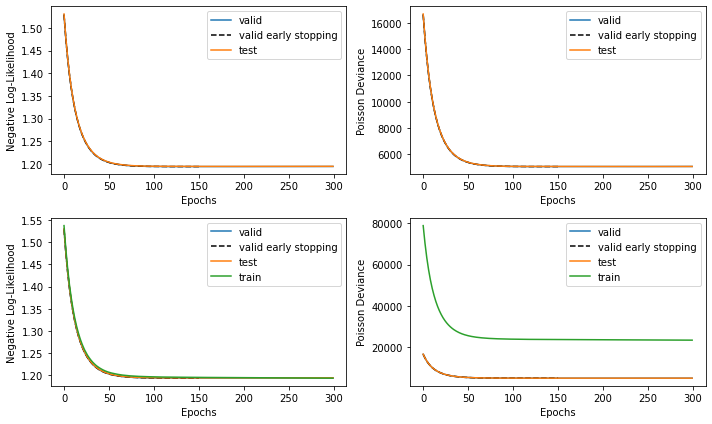

In [33]:
import matplotlib.pyplot as plt
plt.subplots(2,2, figsize=(10,6))
plt.subplot(2,2,1)
plt.plot(progress_wo_es['valid']['poisson-nloglik'], label='valid')
plt.plot(progress['valid']['poisson-nloglik'], label='valid early stopping', linestyle='dashed', color='black')
plt.plot(progress_wo_es['test']['poisson-nloglik'], label='test')
plt.xlabel('Epochs'); plt.ylabel('Negative Log-Likelihood'); plt.legend(); plt.tight_layout()
plt.subplot(2,2,2)
plt.plot(progress_wo_es['valid']['dev_poisson'], label='valid')
plt.plot(progress['valid']['dev_poisson'], label='valid early stopping', linestyle='dashed', color='black')
plt.plot(progress_wo_es['test']['dev_poisson'], label='test')
plt.xlabel('Epochs'); plt.ylabel('Poisson Deviance'); plt.legend(); plt.tight_layout()
plt.subplot(2,2,3)
plt.plot(progress_wo_es['valid']['poisson-nloglik'], label='valid')
plt.plot(progress['valid']['poisson-nloglik'], label='valid early stopping', linestyle='dashed', color='black')
plt.plot(progress_wo_es['test']['poisson-nloglik'], label='test')
plt.plot(progress_wo_es['train']['poisson-nloglik'], label='train')
plt.xlabel('Epochs'); plt.ylabel('Negative Log-Likelihood'); plt.legend(); plt.tight_layout()
plt.subplot(2,2,4)
plt.plot(progress_wo_es['valid']['dev_poisson'], label='valid')
plt.plot(progress['valid']['dev_poisson'], label='valid early stopping', linestyle='dashed', color='black')
plt.plot(progress_wo_es['test']['dev_poisson'], label='test')
plt.plot(progress_wo_es['train']['dev_poisson'], label='train')
plt.xlabel('Epochs'); plt.ylabel('Poisson Deviance'); plt.legend(); plt.tight_layout(); plt.show()

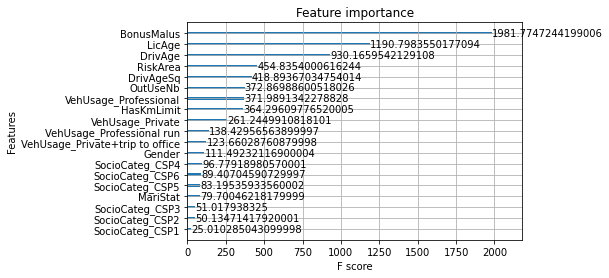

In [34]:
# Отбор признаков (Feature Importance)

importance_type = ['total_gain', 'gain', 'weight', 'total_cover', 'cover']
xgb.plot_importance(xgb_freq, importance_type=importance_type[0]); plt.show()

### Построение модели градиентного бустинга для среднего убытка

In [0]:
# Конвертация наборов данных в формат, поддерживающийся XGBoost

train_ac = xgb.DMatrix(x_train_ac.drop(['Exposure'], axis=1), (y_train_ac))
valid_ac = xgb.DMatrix(x_valid_ac.drop(['Exposure'], axis=1), (y_valid_ac))
test_ac = xgb.DMatrix(x_test_ac.drop(['Exposure'], axis=1), (y_test_ac))

In [0]:
# Зададим функцию Deviance для гамма-распределения

def xgb_eval_dev_gamma(yhat, dtrain):
    """
    Function for Gamma Deviance evaluation

    :param yhat: np.ndarray object with predictions
    :param dtrain: xgb.DMatrix object with target variable
    :return: (str, float), tuple with metrics name and its value
    """
    y = dtrain.get_label()
    return 'dev_gamma', 2 * np.sum(-np.log(y/yhat) + (y-yhat)/yhat)

In [0]:
# Определим границы, в которых будем искать гиперпараметры 

space_avgclm = {'data': train_ac,
                'objective': 'reg:gamma',
                'feval': xgb_eval_dev_gamma,
                'maximize': False,
                'nfold': 5,
                'early_stopping_rounds': 20,
                'num_boost_round': 300,  # hp.choice('num_boost_round', [50, 300, 500])
                'max_depth': hp.choice('max_depth', [5, 8, 10, 12, 15]),
                'min_child_weight': hp.uniform('min_child_weight', 0, 50),
                'subsample': hp.uniform('subsample', 0.5, 1),
                'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
                'alpha': hp.uniform('alpha', 0, 1),
                'lambda': hp.uniform('lambda', 0, 1),
                'eta': hp.uniform('eta', 0.01, 1),
                }        

In [41]:
# Оптимизация (количество итераций снижено для ускорения работы)

best = fmin(fn=objective, space=space_avgclm, algo=tpe.suggest, max_evals=50)

100%|██████████| 50/50 [02:29<00:00,  2.98s/it, best loss: 3221.9752442]


In [42]:
# Оптимальные гиперпараметры 

best_params = space_eval(space_avgclm, best)
best_params

{'alpha': 0.22459945958451633,
 'colsample_bytree': 0.5012964129906392,
 'data': <xgboost.core.DMatrix at 0x7f15a6f8f128>,
 'early_stopping_rounds': 20,
 'eta': 0.16835899828037104,
 'feval': <function __main__.xgb_eval_dev_gamma>,
 'lambda': 0.15362116165279732,
 'max_depth': 5,
 'maximize': False,
 'min_child_weight': 48.56824692801494,
 'nfold': 5,
 'num_boost_round': 300,
 'objective': 'reg:gamma',
 'subsample': 0.8474767426160297}

In [0]:
# Построение модели с ранней остановкой (early stopping)

progress = dict()
xgb_avgclaim = train_xgb_best_params(best_params, train_ac, [(train_ac, "train"),(valid_ac, "valid")], early_stopping_rounds=10, evals_result=progress, verbose_eval=False)

In [0]:
# Построение модели без ранней остановки

progress_wo_es = dict()
xgb_freq_wo_es = train_xgb_best_params(best_params, train_ac, [(train_ac, "train"),(valid_ac, "valid"), (test_ac, "test")], early_stopping_rounds=None, evals_result=progress_wo_es, verbose_eval=False)

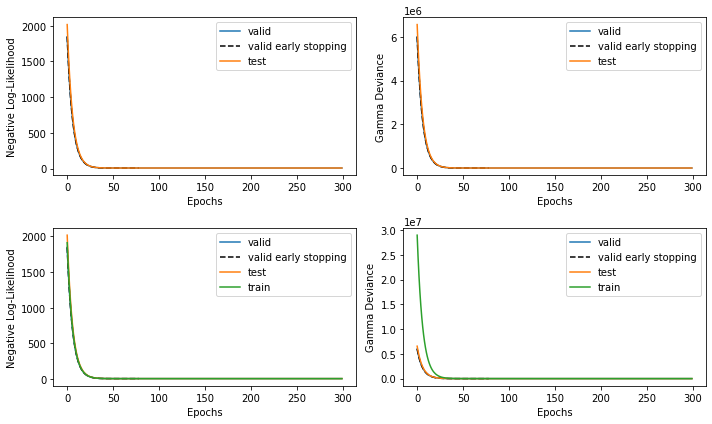

In [45]:
plt.subplots(2,2, figsize=(10,6))
plt.subplot(2,2,1)
plt.plot(progress_wo_es['valid']['gamma-nloglik'], label='valid')
plt.plot(progress['valid']['gamma-nloglik'], label='valid early stopping', linestyle='dashed', color='black')
plt.plot(progress_wo_es['test']['gamma-nloglik'], label='test')
plt.xlabel('Epochs'); plt.ylabel('Negative Log-Likelihood'); plt.legend(); plt.tight_layout()
plt.subplot(2,2,2)
plt.plot(progress_wo_es['valid']['dev_gamma'], label='valid')
plt.plot(progress['valid']['dev_gamma'], label='valid early stopping', linestyle='dashed', color='black')
plt.plot(progress_wo_es['test']['dev_gamma'], label='test')
plt.xlabel('Epochs'); plt.ylabel('Gamma Deviance'); plt.legend(); plt.tight_layout()
plt.subplot(2,2,3)
plt.plot(progress_wo_es['valid']['gamma-nloglik'], label='valid')
plt.plot(progress['valid']['gamma-nloglik'], label='valid early stopping', linestyle='dashed', color='black')
plt.plot(progress_wo_es['test']['gamma-nloglik'], label='test')
plt.plot(progress_wo_es['train']['gamma-nloglik'], label='train')
plt.xlabel('Epochs'); plt.ylabel('Negative Log-Likelihood'); plt.legend(); plt.tight_layout()
plt.subplot(2,2,4)
plt.plot(progress_wo_es['valid']['dev_gamma'], label='valid')
plt.plot(progress['valid']['dev_gamma'], label='valid early stopping', linestyle='dashed', color='black')
plt.plot(progress_wo_es['test']['dev_gamma'], label='test')
plt.plot(progress_wo_es['train']['dev_gamma'], label='train')
plt.xlabel('Epochs'); plt.ylabel('Gamma Deviance'); plt.legend(); plt.tight_layout(); plt.show()

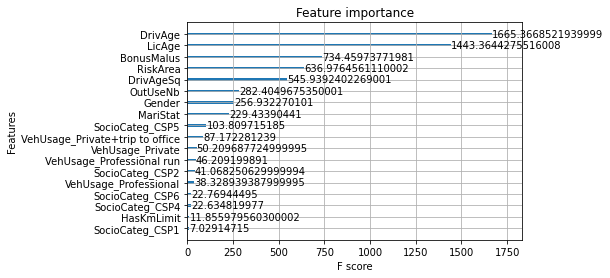

In [46]:
# Отбор признаков (Feature Importance)

importance_type = ['total_gain', 'gain', 'weight', 'total_cover', 'cover']
xgb.plot_importance(xgb_avgclaim, importance_type=importance_type[0]); plt.show()

### Интерпретация моделей градиентного бустинга

* [Lundberg S. M., Erion G. G., Lee S. I. Consistent individualized feature attribution for tree ensembles](https://arxiv.org/abs/1802.03888)
* [SHAP GitHub](https://github.com/slundberg/shap)
* [Explain Your Model with the SHAP Values](https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d)

In [35]:
!pip install shap

     |████████████████████████████████| 276kB 2.0MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394121 sha256=c070f8cad547bd3792f272b231dabd1fd8936cb92f6c549f94426f5236fd3bd7
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [0]:
import shap

In [47]:
explainer = shap.TreeExplainer(xgb_avgclaim)
shap_values = explainer.shap_values(x_test_ac.drop(['Exposure'], axis=1))

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [48]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], x_test_ac.drop(['Exposure'], axis=1).iloc[0,:])

In [49]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, x_test_ac.drop(['Exposure'], axis=1))

Output hidden; open in https://colab.research.google.com to view.

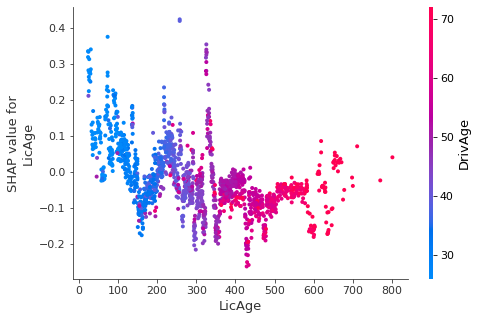

In [50]:
shap.dependence_plot("LicAge", shap_values, x_test_ac.drop(['Exposure'], axis=1))

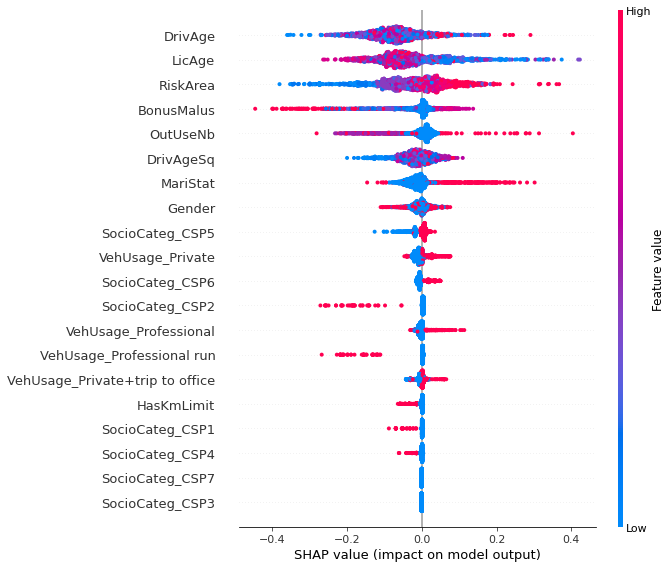

In [51]:
shap.summary_plot(shap_values, x_test_ac.drop(['Exposure'], axis=1))

In [83]:
x_test_ac.BonusMalus.unique()

array([ 50,  80, 100,  77,  90,  61,  57,  60,  64,  62,  51,  68,  72,
        55,  54,  95,  56,  76,  58,  52,  67, 101,  85,  65, 112,  71,
        73,  53, 148, 147,  59, 106, 125,  70,  87, 118,  86,  63,  69,
        74,  79,  75,  66, 111,  81,  78, 156,  98, 132])

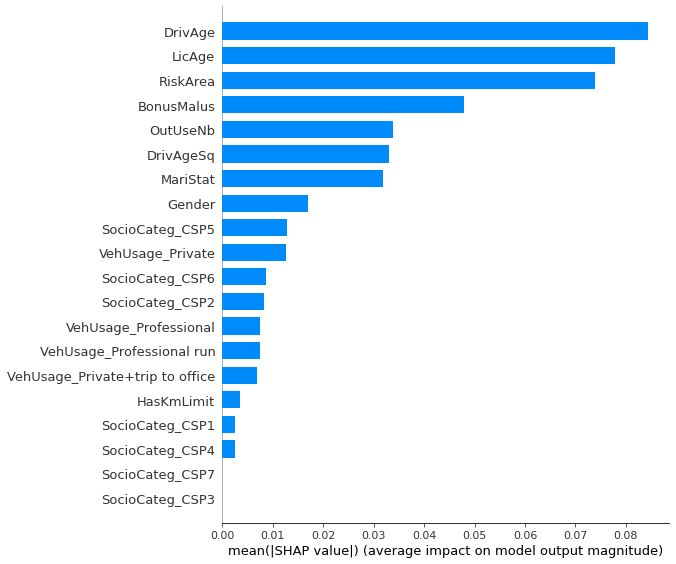

In [52]:
shap.summary_plot(shap_values, x_test_ac.drop(['Exposure'], axis=1), plot_type="bar")

* [ELI5 Documentation](https://eli5.readthedocs.io/en/latest/index.html)
* [Константин Лопухин, ELI5: как понять, что выучила ваша ML модель](https://www.youtube.com/watch?v=pqqcUzj3R90)

In [53]:
!pip install eli5

     |████████████████████████████████| 112kB 2.4MB/s 


In [54]:
import eli5

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
Using TensorFlow backend.


In [55]:
eli5.show_weights(xgb_avgclaim)

Weight,Feature
0.0837,VehUsage_Private+trip to office
0.0816,MariStat
0.0779,LicAge
0.0740,VehUsage_Professional run
0.0667,Gender
0.0631,RiskArea
0.0616,OutUseNb
0.0608,DrivAge
0.0564,DrivAgeSq
0.0563,SocioCateg_CSP2


In [56]:
eli5.explain_prediction(xgb_avgclaim, x_test_ac.drop(['Exposure'], axis=1).iloc[0,:])

Explanation(estimator='<xgboost.core.Booster object at 0x7f15a6f83198>', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=7.764120736302756, std=None, value=1.0), FeatureWeight(feature='LicAge', weight=0.13081583689849957, std=None, value=335.0), FeatureWeight(feature='OutUseNb', weight=0.022162870591644783, std=None, value=0.0), FeatureWeight(feature='Gender', weight=0.011856775950039845, std=None, value=1.0), FeatureWeight(feature='BonusMalus', weight=0.010379855689935488, std=None, value=50.0), FeatureWeight(feature='SocioCateg_CSP2', weight=0.0036206454877542723, std=None, value=0.0), FeatureWeight(feature='VehUsage_Professional run', weight=0.002791397568131123, std=None, value=0.0), FeatureWeight(feature='SocioCateg_CSP5', weight=0.0019683238879980337, std=None, value=1.0), FeatureWeight(feature='HasKmLimit', weight=0.001605895280843261, std=None, value=0.0), FeatureWeight(feature='SocioCateg_CSP1', weight=0.0011399846486986904, std=None, value=0.0), FeatureWeight(feature='SocioCateg_CSP4', weight=0.0010321012240457838, std=None, value=0.0)], neg=[FeatureWeight(feature='DrivAge', weight=-0.0895960732859874, std=None, value=47.0), FeatureWeight(feature='RiskArea', weight=-0.06901422062878204, std=None, value=7.0), FeatureWeight(feature='DrivAgeSq', weight=-0.04474305230739091, std=None, value=2209.0), FeatureWeight(feature='MariStat', weight=-0.034778648159197074, std=None, value=0.0), FeatureWeight(feature='SocioCateg_CSP6', weight=-0.009880313136775124, std=None, value=0.0), FeatureWeight(feature='VehUsage_Private', weight=-0.003980579991879124, std=None, value=0.0), FeatureWeight(feature='VehUsage_Professional', weight=-0.001507139960334726, std=None, value=0.0)], pos_remaining=0, neg_remaining=0), proba=None, score=7.697994396060001, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

### Использование моделей градиентного бустинга

In [0]:
predictions = pd.DataFrame()
predictions['CountPredicted'] = xgb_freq.predict(xgb.DMatrix(df.drop(['ClaimsCount', 'Exposure', 'ClaimAmount', 'ClaimInd'], axis=1))) - 1
predictions['AvgClaimPredicted'] = xgb_avgclaim.predict(xgb.DMatrix(df.drop(['ClaimsCount', 'Exposure', 'ClaimAmount', 'ClaimInd'], axis=1)))

In [0]:
predictions['CountPredicted'].min()

0.023524165153503418

In [0]:
predictions['BurningCost'] = predictions.CountPredicted * predictions.AvgClaimPredicted
predictions.head()

,CountPredicted,AvgClaimPredicted,BurningCost
0,0.247885,1413.176636,350.305267
1,0.247885,1413.176636,350.305267
2,0.198007,764.617126,151.399628
3,0.176441,1004.355469,177.209564
4,0.146209,1015.057861,148.410477


Об особенностях сохранения моделей:

In [0]:
xgb_avgclaim.save_model('/avg_claim.model')

In [0]:
xgb_avgclaim.feature_names

['LicAge',
 'Gender',
 'MariStat',
 'DrivAge',
 'HasKmLimit',
 'BonusMalus',
 'OutUseNb',
 'RiskArea',
 'VehUsage_Private',
 'VehUsage_Private+trip to office',
 'VehUsage_Professional',
 'VehUsage_Professional run',
 'SocioCateg_CSP1',
 'SocioCateg_CSP2',
 'SocioCateg_CSP3',
 'SocioCateg_CSP4',
 'SocioCateg_CSP5',
 'SocioCateg_CSP6',
 'SocioCateg_CSP7',
 'DrivAgeSq']

In [0]:
xgb_avgclaim.feature_types

['int',
 'int',
 'int',
 'int',
 'int',
 'int',
 'float',
 'float',
 'int',
 'int',
 'int',
 'int',
 'int',
 'int',
 'int',
 'int',
 'int',
 'int',
 'int',
 'int']

In [0]:
model =xgb.Booster()
model.load_model('/avg_claim.model')

In [0]:
print(model.feature_names)
type(model.feature_names)

None


NoneType

In [0]:
model.feature_types

AttributeError: ignored

### * Домашнее задание: Многоклассовая классификация

В текущем домашнем задание предлагается взглянуть на задачу моделирования количества страховых случаев как на задачу многоклассовой классификации.

In [0]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from hyperopt import hp, tpe, space_eval
from hyperopt.fmin import fmin

def SeriesFactorizer(series):
    series, unique = pd.factorize(series)
    reference = {x: i for x, i in enumerate(unique)}
    print(reference)
    return series, reference

In [0]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/freMPL-R.csv', low_memory=False)

In [0]:
df = df.loc[df.Dataset.isin([5, 6, 7, 8, 9])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Exposure           115155 non-null  float64
 1   LicAge             115155 non-null  int64  
 2   RecordBeg          115155 non-null  object 
 3   RecordEnd          59455 non-null   object 
 4   Gender             115155 non-null  object 
 5   MariStat           115155 non-null  object 
 6   SocioCateg         115155 non-null  object 
 7   VehUsage           115155 non-null  object 
 8   DrivAge            115155 non-null  int64  
 9   HasKmLimit         115155 non-null  int64  
 10  BonusMalus         115155 non-null  int64  
 11  ClaimAmount        115155 non-null  float64
 12  ClaimInd           115155 non-null  int64  
 13  ClaimNbResp        115155 non-null  float64
 14  ClaimNbNonResp     115155 non-null  float64
 15  ClaimNbParking     115155 non-null  float64
 16  Cl

Предобработайте данные

In [0]:
'<Ваш код здесь>'

'<Ваш код здесь>'

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 24 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Exposure                         115155 non-null  float64
 1   LicAge                           115155 non-null  int64  
 2   Gender                           115155 non-null  int64  
 3   MariStat                         115155 non-null  int64  
 4   DrivAge                          115155 non-null  int64  
 5   HasKmLimit                       115155 non-null  int64  
 6   BonusMalus                       115155 non-null  int64  
 7   ClaimAmount                      115155 non-null  float64
 8   ClaimInd                         115155 non-null  int64  
 9   OutUseNb                         115155 non-null  float64
 10  RiskArea                         115155 non-null  float64
 11  VehUsage_Private                 115155 non-null  uint8  
 12  Ve

XGBoost для многоклассовой классификации принимает на вход значения меток классов в виде `[0, num_classes]`. Заменим значение 11 на 10.

In [0]:
'<Ваш код здесь>'

array([ 0.,  4.,  2.,  1.,  3.,  5.,  6.,  7.,  8.,  9., 11.])

Посмотрим, сколько полисов соответствуют каждому из значений `ClaimsCount`, используя метод `groupby`. Для полученных значений также посчитаем нормированную частоту.

In [0]:
FreqCount = pd.DataFrame('<Ваш код здесь>', columns=['Count'])
FreqCount['Freq'] = '<Ваш код здесь>'

In [0]:
FreqCount.Freq.plot(kind='bar')
plt.ylabel('Frequency')
plt.show()

In [0]:
FreqCount

Заметим, что в данном случае присутствует проблема несбалансированности классов. Поэтому, для того, чтобы по возможности избежать ее, воспользуемся взвешиванием наблюдений для обучения модели. Для этого в исходном наборе данных создадим столбец `weight`. Присвоим ему некоторые значения, например, можно задать `0.05` для значений `ClaimsCount` 0, а для остальных - 1 (Для этого можем использовать функцию `np.where`). Также можно попробовать какой-либо другой способ задания весов, приведенный пример не гарантирует хороших результатов.

In [0]:
df['weight'] = '<Ваш код здесь>'

Разобьем имеющийся набор данных на обучающую, валидационную и тестовую выборки в отношениях 70%/15%/15% соответственно. Зададим зерно для случайного разбиения равным 10.

In [0]:
x_train, x_test, y_train, y_test = train_test_split('<Ваш код здесь>')
x_valid, x_test, y_valid, y_test = train_test_split('<Ваш код здесь>')

Далее, создадим объекты `DMatrix` для обучающей, валидационной и тестовой выборок. Для обучающей выборки также укажем параметр `weight` равным полученному ранее столбцу весов. Данный столбец также нужно исключить из объекта передаваемого в параметр `data`.

In [0]:
xgb_train = '<Ваш код здесь>'
xgb_valid = '<Ваш код здесь>'
xgb_test = '<Ваш код здесь>'

Для оптимизации гиперпараметров можно воспользоваться различными методами.

In [0]:
'<Ваш код здесь>'

Далее обучим нашу модель с оптимальными параметрами

In [0]:
'<Ваш код здесь>'

Посчитаем метрики accuracy и f1 на наших наборах данных, также можем визуализировать confusion matrix, например, с помощью `plt.imshow()`. Можно использовать предложенный ниже код.

In [0]:
dfsets = [{'set': 'train', 'dmat': xgb_train, 'target': y_train},
          {'set': 'valid', 'dmat': xgb_valid, 'target': y_valid},
          {'set': 'test', 'dmat': xgb_test, 'target': y_test}]
for dfset in dfsets:
    class_preds = '<Ваш код здесь>' # Посчитаем предсказанные значения
    print('F1 Score on ' + str(dfset['set'])+':', f1_score('<Ваш код здесь>', average='micro')) # Посчитаем F1 Score

In [0]:
plt.subplots(1,3, figsize=(15,3))
for i in range(len(dfsets)):
    confmatrix = confusion_matrix(dfsets[i]['target'], xgb_multiclass.predict(dfsets[i]['dmat']))
    plt.subplot(1,3,i+1)
    plt.imshow(confmatrix, cmap='Greys')
    plt.colorbar()
    plt.ylabel('True')
    plt.xlabel('Predicted')
plt.show()

Как вы оцениваете качество построенной модели? Какие проблемы могут здесь присутствовать? Как можно улучшить результат?